In [13]:
# ! pip install xgboost

In [14]:
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.over_sampling import ADASYN, SMOTE
from scipy.stats import kurtosis
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.model_selection import (
    GridSearchCV,
    KFold,
    RandomizedSearchCV,
    cross_val_score,
    train_test_split,
)
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.svm import SVC
from xgboost import XGBClassifier

Model is trained and tested on the fourth_batch with train test split.

In [15]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

In [16]:
def engineer_features(df_X, df_y=None):
    # Basic user features
    df_user_features = df_X.groupby("user").agg(
        mean_rating=("rating", "mean"),
        median_rating=("rating", "median"),
        std_rating=("rating", "std"),
        count_dislike=("rating", lambda x: (x == -10).sum()),
        count_neutral=("rating", lambda x: (x == 0).sum()),
        count_like=("rating", lambda x: (x == 10).sum()),
        count_watched=("rating", lambda x: (x == 1).sum()),
        total_interactions=("rating", "count"),
    )

    # Ratio features
    df_user_features["like_ratio"] = (
        df_user_features["count_like"] / df_user_features["total_interactions"]
    )
    df_user_features["dislike_ratio"] = (
        df_user_features["count_dislike"] / df_user_features["total_interactions"]
    )
    df_user_features["neutral_ratio"] = (
        df_user_features["count_neutral"] / df_user_features["total_interactions"]
    )
    df_user_features["watched_ratio"] = (
        df_user_features["count_watched"] / df_user_features["total_interactions"]
    )

    # Weighted scores
    df_user_features["weighted_score"] = (
        df_user_features["count_like"] * 1.5 - df_user_features["count_dislike"] * 1.5
    )

    # Distribution features
    df_user_features["rating_kurtosis"] = df_X.groupby("user")["rating"].apply(
        lambda x: kurtosis(x)
    )

    # Item popularity metrics
    item_popularity = df_X.groupby("item")["rating"].agg(["mean", "count"])
    item_popularity["popularity_score"] = item_popularity["mean"] * np.log1p(
        item_popularity["count"]
    )

    # Fill NaN values in std_rating and rating_kurtosis
    df_user_features["std_rating"] = df_user_features["std_rating"].fillna(0)
    df_user_features["rating_kurtosis"] = df_user_features["rating_kurtosis"].fillna(0)

    # Merge item popularity with user interactions
    df_X_with_popularity = pd.merge(
        df_X, item_popularity["popularity_score"], left_on="item", right_index=True
    )

    # New features
    df_user_features["avg_deviation_from_popularity"] = df_X_with_popularity.groupby(
        "user"
    ).apply(lambda x: np.abs(x["rating"] - x["popularity_score"]).mean())

    # Drop columns with high correlation
    # Count watch has high correlation with total interactions
    df_user_features.drop(columns=["total_interactions"], inplace=True)

    # Drop columns with low mutual information
    df_user_features.drop(columns=["median_rating"], inplace=True)
    df_user_features.drop(columns=["mean_rating"], inplace=True)

    if df_y is not None:
        df_merged = pd.merge(df_user_features.reset_index(), df_y, on="user")
        # Return the merged dataframe with selected features, label, and top features
        return df_merged
    else:
        return df_user_features

In [17]:
# Load fourth batch data
first_data = np.load("data/first_batch_multi_labels.npz")
X1, y1 = pd.DataFrame(first_data['X']), pd.DataFrame(first_data['yy'])

second_data = np.load("data/second_batch_multi_labels.npz")
X2, y2 = pd.DataFrame(second_data['X']), pd.DataFrame(second_data['yy'])

third_data = np.load("data/third_batch_multi_labels.npz")
X3, y3 = pd.DataFrame(third_data['X']), pd.DataFrame(third_data['yy'])

fourth_data = np.load("data/fourth_batch_multi_labels.npz")
X4, y4 = pd.DataFrame(fourth_data['X']), pd.DataFrame(fourth_data['yy'])

# Concat all into fourth
fourth_data = {
    "X": pd.concat([X1, X2, X3, X4], axis = 0).to_numpy(),
    'yy': pd.concat([y1, y2, y3, y4], axis = 0).to_numpy()
}

fourth_interaction_data = pd.DataFrame(
    fourth_data["X"], columns=["user", "item", "rating"]
)
fourth_user_labels = pd.DataFrame(fourth_data["yy"], columns=["user", "label"])
fourth_users = fourth_user_labels["user"].unique()

fourth_users

array([   0,    1,    2, ..., 3787, 3788, 3789], dtype=int64)

In [18]:
fourth_features = engineer_features(fourth_interaction_data)

fourth_features

C:\Users\teoju\AppData\Local\Temp\ipykernel_28416\1038901450.py:56: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ).apply(lambda x: np.abs(x["rating"] - x["popularity_score"]).mean())


,std_rating,count_dislike,count_neutral,count_like,count_watched,like_ratio,dislike_ratio,neutral_ratio,watched_ratio,weighted_score,rating_kurtosis,avg_deviation_from_popularity
user,,,,,,,,,,,,
0,6.167758,20,24,32,57,0.240602,0.150376,0.180451,0.428571,18.0,-0.307358,17.833604
1,5.238997,8,26,19,39,0.206522,0.086957,0.282609,0.423913,16.5,0.535412,13.745883
2,7.380911,32,6,52,58,0.351351,0.216216,0.040541,0.391892,30.0,-1.037700,12.495912
3,6.107906,36,48,43,85,0.202830,0.169811,0.226415,0.400943,10.5,-0.280708,17.111900
4,4.686725,11,54,42,103,0.200000,0.052381,0.257143,0.490476,46.5,0.999560,16.359302
...,...,...,...,...,...,...,...,...,...,...,...,...
3785,4.502136,0,3,4,6,0.307692,0.000000,0.230769,0.461538,6.0,-1.309731,8.032858
3786,6.429423,138,102,54,149,0.121896,0.311512,0.230248,0.336343,-126.0,-0.781821,13.817212
3787,4.962127,3,33,124,72,0.534483,0.012931,0.142241,0.310345,181.5,-0.956307,11.915026


In [47]:
fourth_X = fourth_features
fourth_y = fourth_user_labels["label"]

# Step 1: Split data into 80% for nested cross-validation and 20% for final evaluation
# X_train, X_holdout, y_train, y_holdout = train_test_split(
#     fourth_X, fourth_y, test_size=0.2, random_state=RANDOM_SEED, stratify=fourth_y
# )

X_train = fourth_X
y_train = fourth_y

# print(X_train.shape, X_holdout.shape)

In [20]:
# print("Train set label distribution")
# print(y_train.value_counts())
# print("Holdout set label distribution")
# print(y_holdout.value_counts())

In [21]:
# Upsample the minority class using SMOTE
# smote = SMOTE(random_state=RANDOM_SEED, k_neighbors=2)
# X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# X_train = X_train_resampled
# y_train = y_train_resampled

In [22]:
print(y_train.value_counts())

label
0    3500
1    3500
2    3500
Name: count, dtype: int64


In [23]:
# Scale fourth_fifth_features using StandardScaler and replace the original features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
# X_holdout_scaled = scaler.transform(X_holdout)

X_train_scaled = pd.DataFrame(
    X_train_scaled, index=X_train.index, columns=X_train.columns
)
# X_holdout_scaled = pd.DataFrame(
#     X_holdout_scaled, index=X_holdout.index, columns=X_holdout.columns
# )

In [45]:
# Step 2: Define the inner and outer cross-validation strategy
from sklearn.model_selection import StratifiedKFold
# outer_cv = KFold(
#     n_splits=5, shuffle=True, random_state=42
# )  # Outer loop for model evaluation
inner_cv = KFold(
    n_splits=3, shuffle=True, random_state=42
)  # Inner loop for hyperparameter tuning

outer_cv = StratifiedKFold(
    n_splits=5, shuffle=True, random_state=42
)  # Outer loop for model evaluation
# inner_cv = StratifiedKFold(
#     n_splits=3, shuffle=True, random_state=42
# )  # Inner loop for hyperparameter tuning

In [40]:
def plot_multiclass_roc_curve(y_true, y_pred_probabilities, class_labels=[0, 1, 2]):
    # Convert labels to binary format
    binarized_labels = label_binarize(y_true, classes=np.unique(y_true))
    n_classes = binarized_labels.shape[1]

    # Initialize dictionaries to store metrics
    false_positive_rates = {}
    true_positive_rates = {}
    auc_scores = {}

    # Create color map for plotting
    colors = ["blue", "green", "red"]

    # Create plot
    plt.figure()

    # Calculate ROC curve and AUC for each class
    for class_idx in range(n_classes):
        # Calculate ROC curve metrics
        false_positive_rates[class_idx], true_positive_rates[class_idx], _ = roc_curve(
            binarized_labels[:, class_idx], y_pred_probabilities[:, class_idx]
        )
        # Calculate AUC score
        auc_scores[class_idx] = auc(
            false_positive_rates[class_idx], true_positive_rates[class_idx]
        )

        # Plot ROC curve for current class
        class_label = (
            f"{class_labels[class_idx]}" if class_labels else f"Class {class_idx}"
        )
        plt.plot(
            false_positive_rates[class_idx],
            true_positive_rates[class_idx],
            color=colors[class_idx],
            lw=2,
            label=f"{class_label} (AUC = {auc_scores[class_idx]:.3f})",
        )

    # Calculate and plot average AUC
    average_auc = sum(auc_scores.values()) / n_classes

    # Plot diagonal line
    plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")

    # Customize plot
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic (ROC) Curves")
    plt.text(0.6, 0.3, f"Average AUC Score: {average_auc:.4f}")
    plt.legend(loc="lower right")

    # Show plot
    plt.grid(True, alpha=0.3)
    plt.show()

In [41]:
def calculate_multiclass_roc_auc(y_true, y_pred_proba):
    n_classes = y_pred_proba.shape[1]
    y_true_bin = label_binarize(y_true, classes=np.unique(y_true))

    # Calculate AUC for each class
    auc_scores = {}
    for i in range(n_classes):
        if (
            len(np.unique(y_true_bin[:, i])) > 1
        ):  # Check if the class exists in this fold
            auc_scores[f"class_{i}"] = roc_auc_score(
                y_true_bin[:, i], y_pred_proba[:, i]
            )

    # Calculate macro average
    macro_auc = np.mean(list(auc_scores.values()))

    return macro_auc, auc_scores

C:\Users\teoju\Code\SMU_Code\2024-2025-S1\CS421\cs421-project\cs421-env\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 1 is smaller than n_iter=100. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(



Fold Results:
Macro Average AUC: 0.862
Class-specific AUC scores:
class_0: 0.846
class_1: 0.774
class_2: 0.965


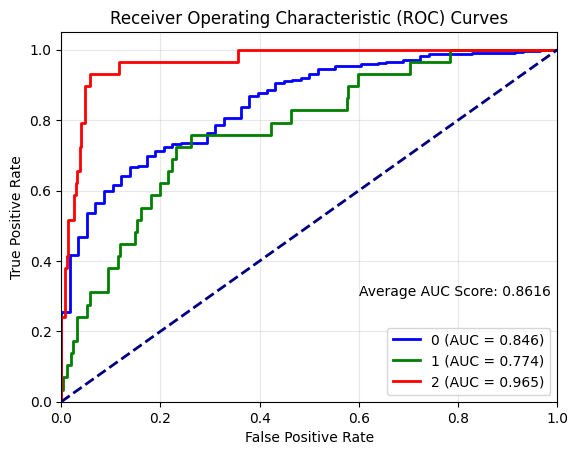

C:\Users\teoju\Code\SMU_Code\2024-2025-S1\CS421\cs421-project\cs421-env\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 1 is smaller than n_iter=100. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(



Fold Results:
Macro Average AUC: 0.855
Class-specific AUC scores:
class_0: 0.887
class_1: 0.716
class_2: 0.964


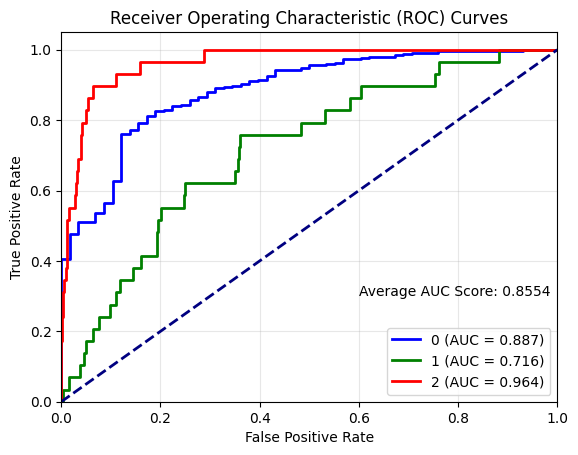

C:\Users\teoju\Code\SMU_Code\2024-2025-S1\CS421\cs421-project\cs421-env\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 1 is smaller than n_iter=100. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(



Fold Results:
Macro Average AUC: 0.868
Class-specific AUC scores:
class_0: 0.887
class_1: 0.762
class_2: 0.956


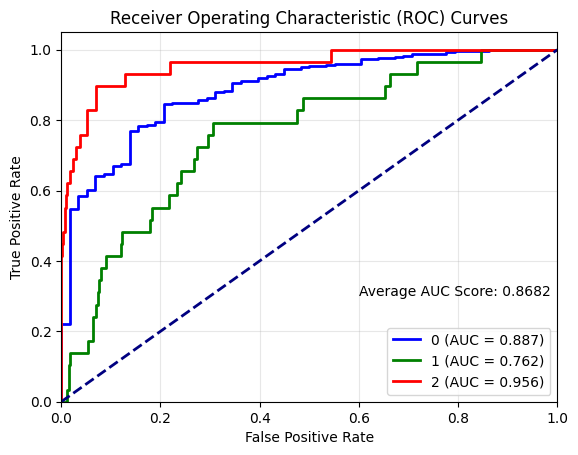

C:\Users\teoju\Code\SMU_Code\2024-2025-S1\CS421\cs421-project\cs421-env\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 1 is smaller than n_iter=100. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(



Fold Results:
Macro Average AUC: 0.861
Class-specific AUC scores:
class_0: 0.868
class_1: 0.753
class_2: 0.961


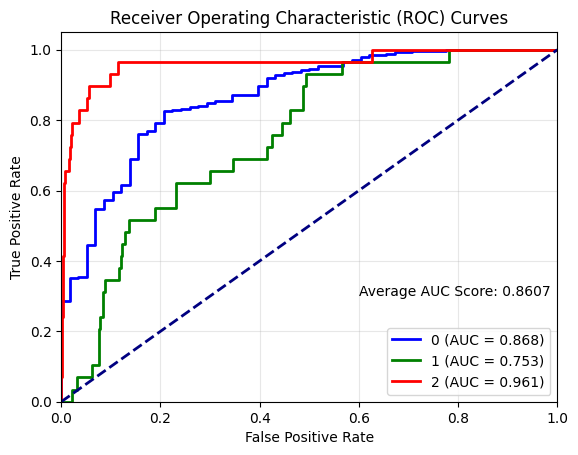

C:\Users\teoju\Code\SMU_Code\2024-2025-S1\CS421\cs421-project\cs421-env\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 1 is smaller than n_iter=100. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(



Fold Results:
Macro Average AUC: 0.916
Class-specific AUC scores:
class_0: 0.917
class_1: 0.838
class_2: 0.992


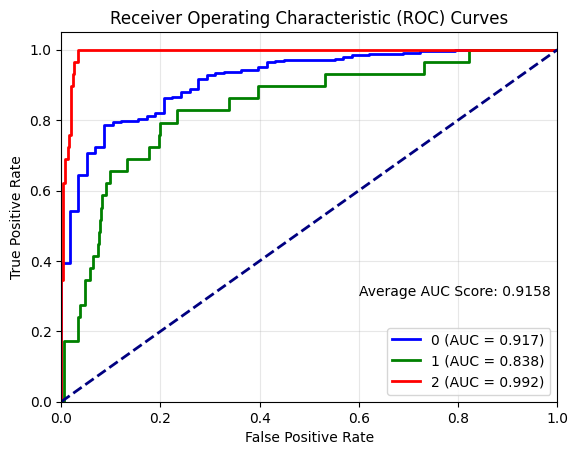


Final Nested CV Results:
Average Macro AUC: 0.872 ± 0.022


In [51]:
# Define Logistic Regression model
logreg_model = LogisticRegression(random_state=RANDOM_SEED, max_iter=1500)

# Define Random Forest model
rf_model = RandomForestClassifier(random_state=RANDOM_SEED)

param_shared = {
    "voting__logreg__C": [0.01],
    "voting__logreg__class_weight": [
        {0: 2.5, 1: 4.5, 2: 1},
    ],
    "voting__rf__max_depth": [50],
    "voting__rf__max_features": [0.5],
    "voting__rf__min_samples_leaf": [1],
    "voting__rf__min_samples_split": [5],
    "voting__rf__n_estimators": [175],
    "voting__rf__bootstrap": [False],
    "voting__rf__min_impurity_decrease": [1e-4],

    "voting__weights": [[1, 1]],
}

# Parameter grid for L1 regularization
param_dist_voting_l1 = {
    "voting__logreg__penalty": ["l1"],
    "voting__logreg__solver": ["liblinear"],
    **param_shared
}

# Define the Voting Classifier
voting_clf = VotingClassifier(
    estimators=[
        ("logreg", logreg_model),
        ("rf", rf_model),
    ],
    voting="soft",  # Use 'soft' voting to combine predicted probabilities
)

# Create a pipeline with the Voting Classifier
pipeline = Pipeline([("voting", voting_clf)])

# Use RandomizedSearchCV instead of GridSearchCV
random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=[param_dist_voting_l1],
    n_iter=100,
    scoring="roc_auc_ovr",
    cv=inner_cv,
    n_jobs=-1,
    random_state=RANDOM_SEED
)

# Perform nested cross-validation
outer_scores = []
class_specific_scores = []

for train_index, test_index in outer_cv.split(X_train, y_train):
    # Split data for current fold
    X_train_fold, X_test_fold = (
        X_train.iloc[train_index],
        X_train.iloc[test_index],
    )
    
    y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]
    
    smote = SMOTE(random_state=RANDOM_SEED, k_neighbors=2)
    scaler = StandardScaler().fit(X_train_fold)
    X_train_scaled = scaler.transform(X_train_fold)
    X_test_scaled = scaler.transform(X_test_fold)
    
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train_fold)

    # Fit GridSearchCV
    random_search.fit(X_train_resampled, y_train_resampled)

    # Get predictions
    y_pred_proba = random_search.best_estimator_.predict_proba(X_test_scaled)

    # Calculate AUC scores
    macro_auc, class_aucs = calculate_multiclass_roc_auc(y_test_fold, y_pred_proba)
    outer_scores.append(macro_auc)
    class_specific_scores.append(class_aucs)

    # Display results for current fold
    print(f"\nFold Results:")
    print(f"Macro Average AUC: {macro_auc:.3f}")
    print("Class-specific AUC scores:")
    for class_name, auc_score in class_aucs.items():
        print(f"{class_name}: {auc_score:.3f}")

    # Plot ROC curve for current fold
    plot_multiclass_roc_curve(
        y_test_fold,
        y_pred_proba,
    )

# Display final nested CV results
print("\nFinal Nested CV Results:")
print("Average Macro AUC: %.3f ± %.3f" % (np.mean(outer_scores), np.std(outer_scores)))

In [68]:
# print(f"Best Hyperparameters: {random_search.best_params_}")
from sklearn.base import clone
# Step 7: Evaluate the final model on the holdout set
# Refit the model with best parameters from the whole training data
best_model_final = clone(random_search.best_estimator_)

scaler = StandardScaler().fit(X_train, y_train)
X_train_scaled = scaler.transform(X_train)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

best_final_model = best_model_final.fit(X_train_resampled, y_train_resampled)

# Test on holdout set and display ROC curve
# y_holdout_pred_probabilities = best_model_final.predict_proba(X_holdout_scaled)
# plot_multiclass_roc_curve(y_holdout, y_holdout_pred_probabilities)

In [69]:
fifth_data_with_labels = np.load("data/fifth_batch_multi_labels.npz")
fifth_user_labels = pd.DataFrame(
    fifth_data_with_labels["yy"], columns=["user", "label"]
)

fifth_interaction_data = pd.DataFrame(
    fifth_data_with_labels["X"], columns=["user", "item", "rating"]
)

fifth_features = engineer_features(fifth_interaction_data)

fifth_features

C:\Users\teoju\AppData\Local\Temp\ipykernel_28416\1038901450.py:56: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ).apply(lambda x: np.abs(x["rating"] - x["popularity_score"]).mean())


,std_rating,count_dislike,count_neutral,count_like,count_watched,like_ratio,dislike_ratio,neutral_ratio,watched_ratio,weighted_score,rating_kurtosis,avg_deviation_from_popularity
user,,,,,,,,,,,,
3790,5.480485,1,3,17,7,0.607143,0.035714,0.107143,0.250000,24.0,0.299984,11.201149
3791,8.989782,6,1,7,3,0.411765,0.352941,0.058824,0.176471,1.5,-1.663088,23.123969
3792,7.011842,19,21,45,32,0.384615,0.162393,0.179487,0.273504,39.0,-0.816920,12.435839
3793,4.976308,0,3,5,3,0.454545,0.000000,0.272727,0.272727,7.5,-1.948977,16.731619
3794,4.826087,12,91,47,73,0.210762,0.053812,0.408072,0.327354,52.5,0.705454,15.927917
...,...,...,...,...,...,...,...,...,...,...,...,...
5435,6.040867,4,12,15,13,0.340909,0.090909,0.272727,0.295455,16.5,-0.346299,18.201929
5436,5.705941,5,17,42,30,0.446809,0.053191,0.180851,0.319149,55.5,-0.322267,15.485094
5437,5.259704,8,39,123,98,0.458955,0.029851,0.145522,0.365672,172.5,-0.517903,13.421144


In [70]:
fifth_features_scaled = scaler.transform(fifth_features)

fifth_features_scaled = pd.DataFrame(
    fifth_features_scaled, index=fifth_features.index, columns=fifth_features.columns
)

fifth_features_scaled

,std_rating,count_dislike,count_neutral,count_like,count_watched,like_ratio,dislike_ratio,neutral_ratio,watched_ratio,weighted_score,rating_kurtosis,avg_deviation_from_popularity
user,,,,,,,,,,,,
3790,0.279774,-0.607764,-0.798366,-0.702804,-1.049945,2.475894,-0.584525,-0.564987,-2.062058,-0.293995,0.369624,-1.377536
3791,4.744228,-0.395200,-0.864214,-0.982212,-1.111096,0.949251,3.446928,-1.135936,-2.741817,-0.700167,-1.495185,2.765444
3792,2.227934,0.157465,-0.205735,0.079539,-0.667755,0.737112,1.025364,0.289846,-1.844767,-0.023213,-0.691372,-0.948502
3793,-0.361630,-0.650277,-0.798366,-1.038094,-1.111096,1.283530,-1.038398,1.391586,-1.851950,-0.591855,-1.766763,0.544210
3794,-0.552738,-0.140124,2.098938,0.135421,-0.040962,-0.621339,-0.354536,2.990839,-1.346939,0.220491,0.754798,0.264937
...,...,...,...,...,...,...,...,...,...,...,...,...
5435,0.992680,-0.480226,-0.502051,-0.758685,-0.958220,0.395600,0.116914,1.391586,-1.641843,-0.429386,-0.244309,1.055118
5436,0.566595,-0.437713,-0.337431,-0.004283,-0.698330,1.223076,-0.362418,0.305962,-1.422795,0.274647,-0.221480,0.111063
5437,-0.001099,-0.310175,0.386895,2.258923,0.341229,1.317987,-0.659042,-0.111488,-0.992705,2.386745,-0.407323,-0.606125


In [71]:
y_pred_proba_fifth = best_model_final.predict_proba(fifth_features_scaled)

df_predictions_fifth = pd.DataFrame(
    {
        "user": fifth_user_labels.index,
        "z0": y_pred_proba_fifth[:, 0],
        "z1": y_pred_proba_fifth[:, 1],
        "z2": y_pred_proba_fifth[:, 2],
        "predicted_class": np.argmax(y_pred_proba_fifth, axis=1),
    }
).set_index("user")

df_predictions_fifth = df_predictions_fifth.join(fifth_user_labels)

df_predictions_fifth

C:\Users\teoju\Code\SMU_Code\2024-2025-S1\CS421\cs421-project\cs421-env\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\teoju\Code\SMU_Code\2024-2025-S1\CS421\cs421-project\cs421-env\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


,z0,z1,z2,predicted_class,user,label
user,,,,,,
0,0.701997,0.297834,0.000169,0,3790,0
1,0.602915,0.044498,0.352586,0,3791,0
2,0.498206,0.467895,0.033899,0,3792,0
3,0.755325,0.243126,0.001550,0,3793,0
4,0.775958,0.223686,0.000355,0,3794,0
...,...,...,...,...,...,...
1645,0.731128,0.260218,0.008654,0,5435,0
1646,0.774974,0.222396,0.002630,0,5436,0
1647,0.942826,0.054915,0.002259,0,5437,0


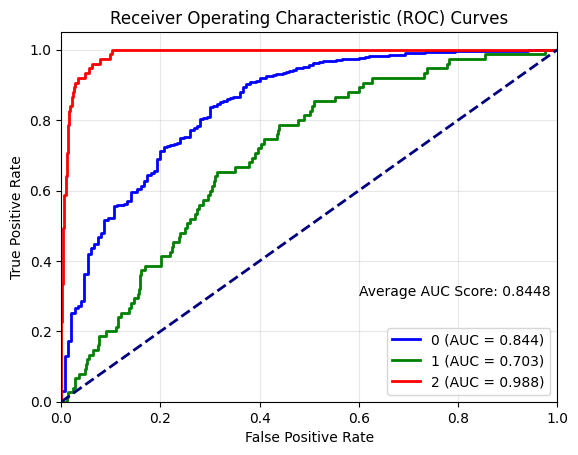

Average ROC AUC: 0.8448


In [72]:
roc_auc = calculate_multiclass_roc_auc(df_predictions_fifth["label"], y_pred_proba_fifth)
plot_multiclass_roc_curve(df_predictions_fifth["label"], y_pred_proba_fifth)

# Average ROC AUC to 4 decimal places
print(f"Average ROC AUC: {roc_auc[0]:.4f}")

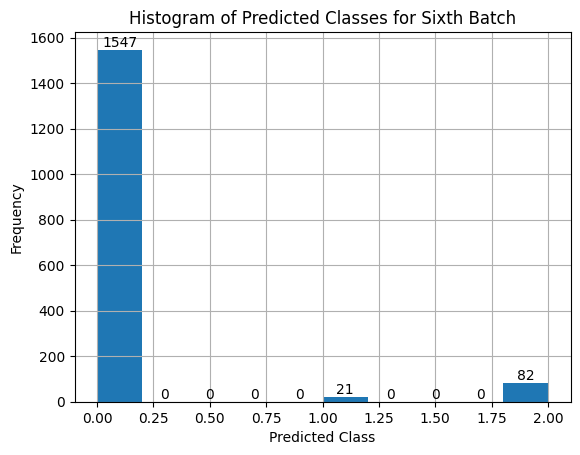

In [73]:
# Plot histogram of predicted classes
ax = df_predictions_fifth["predicted_class"].hist()
plt.title("Histogram of Predicted Classes for Sixth Batch")
plt.xlabel("Predicted Class")
plt.ylabel("Frequency")

# Add frequency labels on each bar
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='bottom')
plt.show()

In [74]:
sixth_data = np.load("data/sixth_batch_multi.npz")

sixth_interaction_data = pd.DataFrame(
    sixth_data["X"], columns=["user", "item", "rating"]
)

sixth_features = engineer_features(sixth_interaction_data)

sixth_features_scaled = scaler.transform(sixth_features)

sixth_features_scaled = pd.DataFrame(
    sixth_features_scaled, index=sixth_features.index, columns=sixth_features.columns
)

sixth_features_scaled

C:\Users\teoju\AppData\Local\Temp\ipykernel_28416\1038901450.py:56: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ).apply(lambda x: np.abs(x["rating"] - x["popularity_score"]).mean())


,std_rating,count_dislike,count_neutral,count_like,count_watched,like_ratio,dislike_ratio,neutral_ratio,watched_ratio,weighted_score,rating_kurtosis,avg_deviation_from_popularity
user,,,,,,,,,,,,
5440,1.088207,0.497568,0.749058,1.728047,0.387092,0.613489,0.178366,0.264061,-1.062185,1.357774,-0.252682,-0.323875
5441,-0.314470,-0.140124,0.880754,-0.395455,-0.300852,-0.809618,-0.021724,2.422816,-0.921875,-0.293995,0.852826,0.911125
5442,-0.787008,-0.097611,1.242917,-0.674863,-0.423153,-1.291468,0.108891,3.502682,-1.291664,-0.591855,1.628582,1.440134
5443,2.757439,0.455055,-0.469127,-0.171928,-0.606604,0.266010,1.938350,-0.447129,-1.374950,-0.456464,-0.972532,1.058164
5444,0.887938,0.752644,1.473384,3.488319,1.105610,0.838719,-0.039879,0.194624,-1.115574,2.901230,-0.208842,-0.888419
...,...,...,...,...,...,...,...,...,...,...,...,...
7635,0.220967,-0.607764,-0.765442,-0.674863,-1.034658,2.268847,-0.628448,-0.306338,-1.987504,-0.266917,0.075765,-0.104206
7636,1.291345,4.621306,2.131862,0.107480,1.136185,-1.395778,2.786468,0.807557,-1.007441,-2.839344,-0.587532,0.030225
7637,-1.037616,-0.607764,-0.172811,-0.674863,-0.713618,-0.258932,-0.856849,1.882648,-0.543282,-0.266917,-0.038520,-0.295783


In [75]:
y_pred_proba_sixth = best_model_final.predict_proba(sixth_features_scaled)

df_predictions_sixth = pd.DataFrame(
    {
        "user": sixth_features_scaled.index,
        "z0": y_pred_proba_sixth[:, 0],
        "z1": y_pred_proba_sixth[:, 1],
        "z2": y_pred_proba_sixth[:, 2],
        "predicted_class": np.argmax(y_pred_proba_sixth, axis=1),
    }
).set_index("user")

df_predictions_sixth

C:\Users\teoju\Code\SMU_Code\2024-2025-S1\CS421\cs421-project\cs421-env\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\teoju\Code\SMU_Code\2024-2025-S1\CS421\cs421-project\cs421-env\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


,z0,z1,z2,predicted_class
user,,,,
5440,0.907054,0.063175,0.029771,0
5441,0.760794,0.237098,0.002108,0
5442,0.755096,0.244075,0.000829,0
5443,0.489847,0.135641,0.374512,0
5444,0.970166,0.012044,0.017790,0
...,...,...,...,...
7635,0.722672,0.276952,0.000377,0
7636,0.822308,0.054901,0.122790,0
7637,0.731939,0.267446,0.000615,0


In [77]:
df_final = df_predictions_sixth.drop(['predicted_class'], axis = 'columns')
df_final

,z0,z1,z2
user,,,
5440,0.907054,0.063175,0.029771
5441,0.760794,0.237098,0.002108
5442,0.755096,0.244075,0.000829
5443,0.489847,0.135641,0.374512
5444,0.970166,0.012044,0.017790
...,...,...,...
7635,0.722672,0.276952,0.000377
7636,0.822308,0.054901,0.122790
7637,0.731939,0.267446,0.000615


In [78]:
np.savez("cs421-g1-team3-week11-v2.0.npz",scores=df_final.to_numpy())

In [80]:
assert np.isclose(np.sum(np.load("cs421-g1-team3-week11-v2.0.npz")['scores'][0]), 1.0)

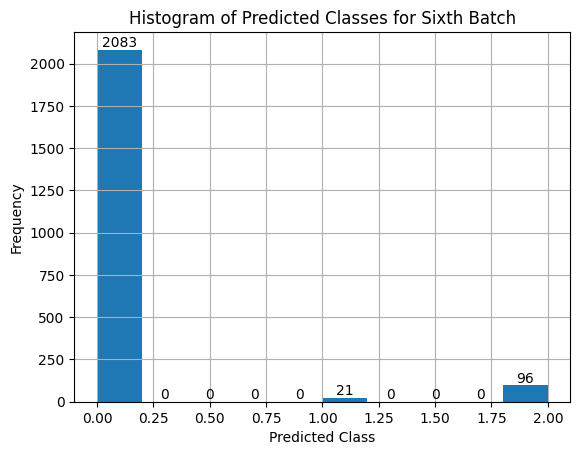

In [36]:
# Plot histogram of predicted classes
ax = df_predictions_sixth["predicted_class"].hist()
plt.title("Histogram of Predicted Classes for Sixth Batch")
plt.xlabel("Predicted Class")
plt.ylabel("Frequency")

# Add frequency labels on each bar
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='bottom')
plt.show()